In [9]:
# Fraud Detection in Financial Transactions Project

## Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam


In [7]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')


Dataset shape: (51786, 31)
Class
0.0    51635
1.0      150
Name: count, dtype: int64


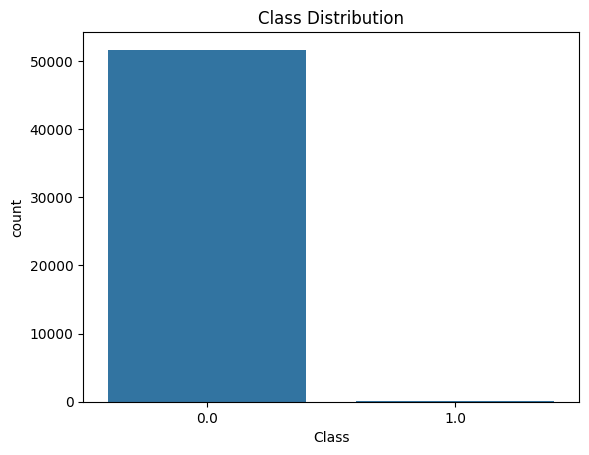

In [10]:
## Step 2: Load and Explore the Dataset
df = pd.read_csv("creditcard.csv")
print("Dataset shape:", df.shape)
print(df["Class"].value_counts())

# Plot class distribution
sns.countplot(x='Class', data=df)
plt.title("Class Distribution")
plt.show()

In [11]:
## Step 3: Data Preprocessing

# Handle missing values in 'Class' column before splitting
df.dropna(subset=['Class'], inplace=True)  # Remove rows with NaN in 'Class'

# Separate features and target after handling missing values
X = df.drop("Class", axis=1)
y = df["Class"]

# Now you can split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

--- Isolation Forest Results ---
Confusion Matrix:
[[10313    14]
 [   16    14]]
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10327
         1.0       0.50      0.47      0.48        30

    accuracy                           1.00     10357
   macro avg       0.75      0.73      0.74     10357
weighted avg       1.00      1.00      1.00     10357

ROC AUC Score: 0.02332074497272521


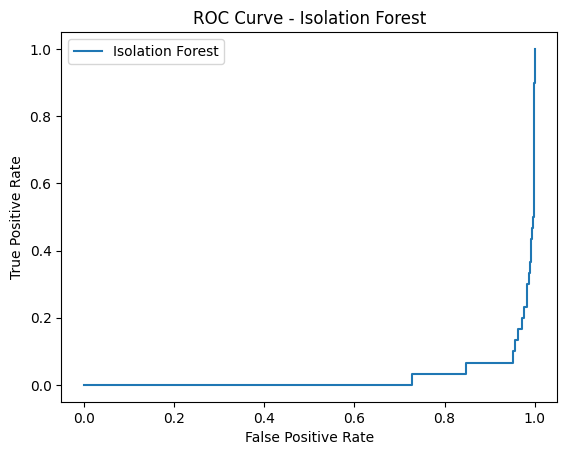

In [12]:
## Step 4: Isolation Forest Model

iso_forest = IsolationForest(n_estimators=100, contamination=0.0017, random_state=42)
iso_forest.fit(X_train)
y_pred_scores = iso_forest.decision_function(X_test)
y_pred = iso_forest.predict(X_test)

# Convert predictions (-1 for anomaly, 1 for normal) to binary classes
y_pred = [1 if x == -1 else 0 for x in y_pred]

print("--- Isolation Forest Results ---")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, y_pred_scores))

fpr, tpr, _ = roc_curve(y_test, y_pred_scores)
plt.plot(fpr, tpr, label='Isolation Forest')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Isolation Forest")
plt.legend()
plt.show()

324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
--- Autoencoder Results ---
Confusion Matrix:
[[10150   177]
 [   30     0]]
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     10327
         1.0       0.00      0.00      0.00        30

    accuracy                           0.98     10357
   macro avg       0.50      0.49      0.49     10357
weighted avg       0.99      0.98      0.99     10357

ROC AUC Score: 0.40915399761143934


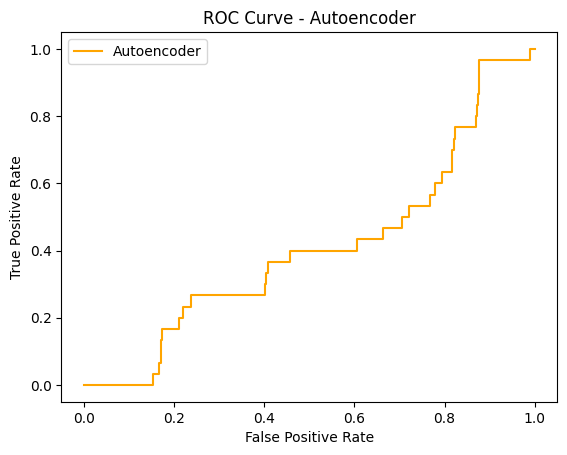

In [13]:
## Step 5: Autoencoder Model

X_train_auto = X_train[y_train == 0]  # Train only on non-fraud cases

input_dim = X_train_auto.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(14, activation='relu')(input_layer)
encoded = Dense(7, activation='relu')(encoded)
decoded = Dense(14, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
autoencoder.fit(X_train_auto, X_train_auto, epochs=10, batch_size=64, shuffle=True, validation_split=0.2, verbose=0)

# Get reconstruction error on test set
X_test_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

# Set threshold for anomaly detection
threshold = np.percentile(mse, 98.3)
y_pred_auto = [1 if e > threshold else 0 for e in mse]

print("--- Autoencoder Results ---")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_auto))

print("Classification Report:")
print(classification_report(y_test, y_pred_auto))

print("ROC AUC Score:", roc_auc_score(y_test, mse))

fpr_ae, tpr_ae, _ = roc_curve(y_test, mse)
plt.plot(fpr_ae, tpr_ae, label='Autoencoder', color='orange')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Autoencoder")
plt.legend()
plt.show()

In [14]:
## Step 6: Conclusion

# - Isolation Forest and Autoencoder both provide anomaly detection capabilities.
# - Autoencoder uses reconstruction error and is trained on non-fraud cases.
# - Use ROC AUC and F1-score for evaluating model performance.
# - Deploy the most effective model with interpretability tools (e.g., SHAP).
# - Set up feedback loops to adapt to evolving fraud patterns.
